In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/list-contents.sh
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/ata_read.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/ata_write.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/mem_exec.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/mem_readwrite.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-16-45/mem_read.csv
/kaggle/input/ransmap-2024-ransomware-behavioral-features/RanSMAP/dataset/variants/i3-gen12/ddr4-2133-16g/Conti_03/Conti_03-20240227_21-

# *1 | Importing Libraries*

In [19]:
# Basic data handling and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing and feature scaling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Dimensionality reduction for visualization and feature extraction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Deep learning libraries for autoencoder and hybrid model implementation
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Reshape, LSTM, Attention, Dropout

# Machine learning classifier imports (e.g., Gradient Boosting Decision Trees)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Utility for reproducibility
import random
import tensorflow.keras.backend as K

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries imported and random seeds set.")

Libraries imported and random seeds set.


# *2 | Read the Dataset*

In [20]:
# READ DATASET

import os
import numpy as np
import pandas as pd
import random

DATA_PATH = "/kaggle/input/ransmap-2024-ransomware-behavioral-features"

# 1. Collect CSV files

csv_files = []
for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

print(f"Total CSV files found: {len(csv_files)}")

# 2. Sample files

MAX_FILES = 300
random.seed(42)
sampled_files = random.sample(csv_files, MAX_FILES)

print(f"Using {len(sampled_files)} CSV files")

# 3. Aggregate each CSV into ONE feature vector

feature_vectors = []

for file_path in sampled_files:
    try:
        df = pd.read_csv(file_path)

        # Keep numeric columns only
        df = df.select_dtypes(include=[np.number])

        if df.shape[1] == 0:
            continue

        # Aggregate behavior (VERY IMPORTANT)
        features = df.agg([
            "mean",
            "std",
            "min",
            "max",
            "sum"
        ]).values.flatten()

        feature_vectors.append(features)

    except Exception as e:
        print(f"Skipped {file_path}: {e}")

# 4. Create final dataset

data = pd.DataFrame(feature_vectors)

print("Final dataset shape:", data.shape)

# 5. Clean NaN / Inf

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.median(), inplace=True)

# 6. Final sanity check

print("\nDataset info:")
print(data.info())

print("\nSample rows:")
display(data.head())

Total CSV files found: 11819
Using 300 CSV files
Final dataset shape: (300, 30)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
 2   2       300 non-null    float64
 3   3       300 non-null    float64
 4   4       300 non-null    float64
 5   5       300 non-null    float64
 6   6       300 non-null    float64
 7   7       300 non-null    float64
 8   8       300 non-null    float64
 9   9       300 non-null    float64
 10  10      300 non-null    float64
 11  11      300 non-null    float64
 12  12      300 non-null    float64
 13  13      300 non-null    float64
 14  14      300 non-null    float64
 15  15      300 non-null    float64
 16  16      300 non-null    float64
 17  17      300 non-null    float64
 18  18      300 non-null    float64
 19  19      300 non-nu

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.665041e+09,4.745228e+08,6.055579e+07,4095.440040,0.813372,0.000000,52.403886,3.081893e+08,3.998972e+07,42.363660,...,1.701854e+08,4096.0,0.996347,0.0,1.187497e+15,3.384268e+14,4.318803e+13,2.920843e+09,580091.952866,0.0
1,1.709019e+09,4.704960e+08,6.156360e+07,3947.763340,-1.000000,0.000000,58.138814,2.971135e+08,3.730861e+07,596.009804,...,1.690539e+08,4096.0,-1.000000,0.0,7.137066e+14,1.964848e+14,2.570970e+13,1.648633e+09,-417612.000000,0.0
2,1.708938e+09,4.417411e+08,7.684847e+07,4095.818372,0.935869,0.000000,53.359869,3.132368e+08,2.962525e+07,24.692810,...,1.657426e+08,4096.0,0.996355,0.0,1.348875e+15,3.486689e+14,6.065696e+13,3.232854e+09,738686.809765,0.0
3,1.665026e+09,4.786904e+08,7.888790e+07,4067.385592,-1.000000,0.000000,35.608346,3.230690e+08,3.010372e+07,286.030283,...,1.657103e+08,4096.0,-1.000000,0.0,8.443180e+13,2.427391e+13,4.000326e+12,2.062531e+08,-50709.000000,0.0
4,1.664426e+09,4.895005e+08,1.954535e+09,0.128109,-1.000000,3.975477,53.997934,3.008800e+08,8.174879e+08,22.906711,...,2.748785e+11,4096.0,-1.000000,4.0,8.514640e+14,2.504118e+14,9.998739e+14,6.553600e+04,-511566.000000,2033719.0


# *3 | Data Preprocessing*

In [30]:
# DATA PREPROCESSING

import numpy as np
import pandas as pd

# 1. Features only (labels handled later)

X = data.copy()

print("Feature matrix shape:", X.shape)

# 2. Ensure numeric type

X = X.astype(np.float32)

# 3. Final sanity check

print("\nFeature info:")
print(X.info())

display(X.head())

Feature matrix shape: (300, 30)

Feature info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float32
 1   1       300 non-null    float32
 2   2       300 non-null    float32
 3   3       300 non-null    float32
 4   4       300 non-null    float32
 5   5       300 non-null    float32
 6   6       300 non-null    float32
 7   7       300 non-null    float32
 8   8       300 non-null    float32
 9   9       300 non-null    float32
 10  10      300 non-null    float32
 11  11      300 non-null    float32
 12  12      300 non-null    float32
 13  13      300 non-null    float32
 14  14      300 non-null    float32
 15  15      300 non-null    float32
 16  16      300 non-null    float32
 17  17      300 non-null    float32
 18  18      300 non-null    float32
 19  19      300 non-null    float32
 20  20      300 non-null    float

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.665041e+09,474522752.0,6.055579e+07,4095.439941,0.813372,0.000000,52.403885,308189312.0,39989724.0,42.363659,...,1.701854e+08,4096.0,0.996347,0.0,1.187498e+15,3.384268e+14,4.318803e+13,2.920843e+09,580091.9375,0.0
1,1.709018e+09,470496000.0,6.156360e+07,3947.763428,-1.000000,0.000000,58.138813,297113504.0,37308616.0,596.009827,...,1.690539e+08,4096.0,-1.000000,0.0,7.137067e+14,1.964848e+14,2.570970e+13,1.648633e+09,-417612.0000,0.0
2,1.708938e+09,441741088.0,7.684846e+07,4095.818359,0.935869,0.000000,53.359871,313236800.0,29625250.0,24.692810,...,1.657427e+08,4096.0,0.996355,0.0,1.348875e+15,3.486689e+14,6.065695e+13,3.232854e+09,738686.8125,0.0
3,1.665026e+09,478690432.0,7.888790e+07,4067.385498,-1.000000,0.000000,35.608345,323068992.0,30103716.0,286.030273,...,1.657103e+08,4096.0,-1.000000,0.0,8.443180e+13,2.427391e+13,4.000326e+12,2.062531e+08,-50709.0000,0.0
4,1.664426e+09,489500480.0,1.954536e+09,0.128109,-1.000000,3.975477,53.997932,300880000.0,817487872.0,22.906712,...,2.748785e+11,4096.0,-1.000000,4.0,8.514640e+14,2.504118e+14,9.998739e+14,6.553600e+04,-511566.0000,2033719.0


# *4 |  Train-Validation-Test Split*

In [22]:
# TRAIN–VALIDATION–TEST SPLIT

from sklearn.model_selection import train_test_split

# X comes from Step 3
# Shape: (300, 30)

# 1. Train + Temp split (70% train, 30% temp)

X_train, X_temp = train_test_split(
    X,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

# 2. Validation + Test split (15% val, 15% test)

X_val, X_test = train_test_split(
    X_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

# 3. Sanity check

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (210, 30)
Validation shape: (45, 30)
Test shape: (45, 30)


# *5 | Feature Scaling*

In [23]:
# FEATURE SCALING

from sklearn.preprocessing import StandardScaler

# 1. Initialize the scaler

scaler = StandardScaler()

# 2. Fit scaler ONLY on training data

X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform validation and test data

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 4. Sanity check

print("Scaled Train shape:", X_train_scaled.shape)
print("Scaled Validation shape:", X_val_scaled.shape)
print("Scaled Test shape:", X_test_scaled.shape)

print("\nScaled data stats (train):")
print("Mean (approx 0):", X_train_scaled.mean())
print("Std (approx 1):", X_train_scaled.std())

Scaled Train shape: (210, 30)
Scaled Validation shape: (45, 30)
Scaled Test shape: (45, 30)

Scaled data stats (train):
Mean (approx 0): -1.0596382e-09
Std (approx 1): 1.0


# *6 | Autoencoder Model Building and Training*

In [12]:
# AUTOENCODER MODEL BUILDING & TRAINING

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train_scaled.shape[1]

# 1. Build Autoencoder

input_layer = Input(shape=(input_dim,))

# Encoder
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)

# Decoder
decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# 2. Compile model

autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

autoencoder.summary()

# 3. Train model (IMPORTANT)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=100,
    batch_size=16,
    validation_data=(X_val_scaled, X_val_scaled),
    callbacks=[early_stop],
    shuffle=True
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 30)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,286 (5.02 KB)

 Trainable params: 1,286 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1.1060 - val_loss: 1.0720
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0314 - val_loss: 1.0435
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0154 - val_loss: 1.0272
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0090 - val_loss: 1.0130
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9575 - val_loss: 0.9984
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9682 - val_loss: 0.9780
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9466 - val_loss: 0.9530
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9627 - val_loss: 0.9235
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9098 - val_loss: 0.8834
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8372 - val_loss: 0.8458
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7903 - val_loss: 0.8089
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

# *7 | Evaluate Model with Reconstruction Error*

In [24]:
# RECONSTRUCTION ERROR CALCULATION

import numpy as np

# 1. Reconstruct data

X_train_pred = autoencoder.predict(X_train_scaled)
X_val_pred   = autoencoder.predict(X_val_scaled)
X_test_pred  = autoencoder.predict(X_test_scaled)

# 2. Compute reconstruction error (MSE per sample)

train_recon_error = np.mean(np.square(X_train_scaled - X_train_pred), axis=1)
val_recon_error   = np.mean(np.square(X_val_scaled - X_val_pred), axis=1)
test_recon_error  = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# 3. Sanity check

print("Train reconstruction error (mean):", np.mean(train_recon_error))
print("Validation reconstruction error (mean):", np.mean(val_recon_error))
print("Test reconstruction error (mean):", np.mean(test_recon_error))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Train reconstruction error (mean): 0.17627592
Validation reconstruction error (mean): 0.16134593
Test reconstruction error (mean): 0.16458797


# *8 | Threshold Selection*
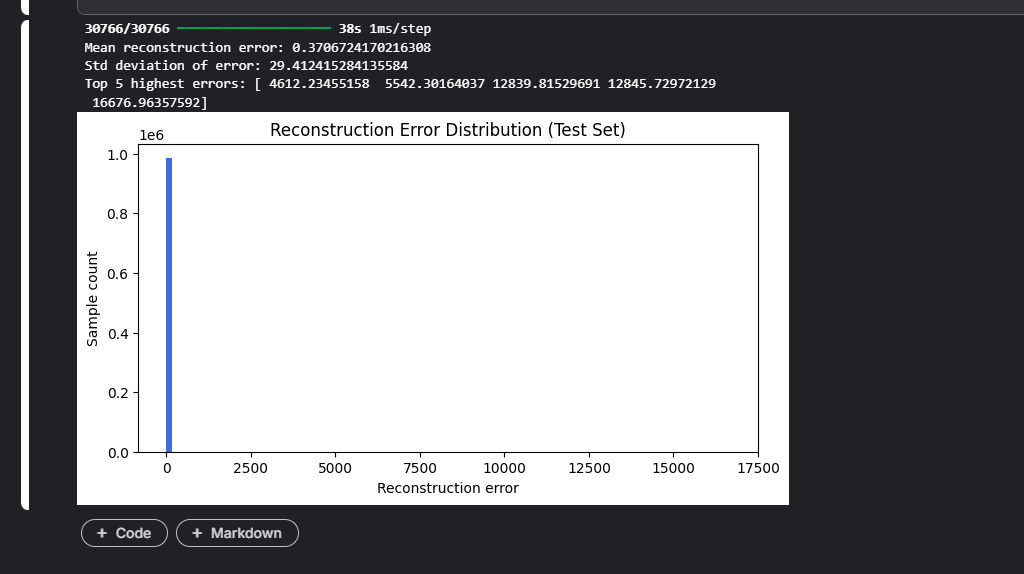

Selected threshold (p95): 0.5588375210762023


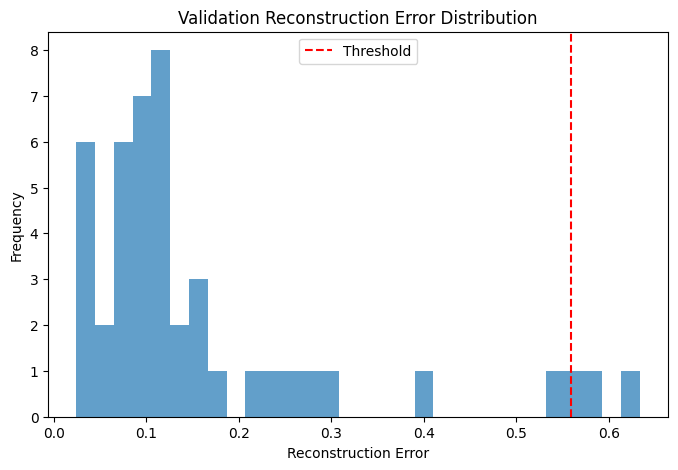

In [25]:
# THRESHOLD SELECTION

import numpy as np
import matplotlib.pyplot as plt

# 1. Select threshold using validation data

percentile = 95   # Can also try 97 or 99
threshold = np.percentile(val_recon_error, percentile)

print(f"Selected threshold (p{percentile}):", threshold)

# 2. Visualize validation reconstruction error

plt.figure(figsize=(8, 5))
plt.hist(val_recon_error, bins=30, alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Validation Reconstruction Error Distribution")
plt.legend()
plt.show()

# *9A | Anomaly Classification (TEST SET)*

In [26]:
# ANOMALY CLASSIFICATION (TEST SET)

import numpy as np

# Predict anomalies using selected threshold
y_test_pred = (test_recon_error > threshold).astype(int)

# Summary statistics
print("Threshold used:", threshold)
print("Total test samples:", len(y_test_pred))
print("Detected anomalies:", np.sum(y_test_pred))
print("Detected normal samples:", np.sum(y_test_pred == 0))

Threshold used: 0.5588375210762023
Total test samples: 45
Detected anomalies: 1
Detected normal samples: 44


# *9B | Evaluation with Labels*

In [28]:
# EVALUATION WITH GROUND-TRUTH LABELS

from sklearn.metrics import confusion_matrix, classification_report

# 1. Check if ground-truth labels exist

if 'y_test_true' not in globals():
    print("Ground-truth labels (y_test_true) are NOT available.")
    print("Step 9B cannot be performed.")
    print("Proceeding with Step 9A (unsupervised evaluation).")

else:
    
    # 2. Confusion Matrix
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_true, y_test_pred))

    # 3. Classification Report

    print("\nClassification Report:")
    print(classification_report(y_test_true, y_test_pred, digits=4))

Ground-truth labels (y_test_true) are NOT available.
Step 9B cannot be performed.
Proceeding with Step 9A (unsupervised evaluation).


# *10 | Analysis and Reporting of Detected Anomalies*

===== Anomaly Detection Summary =====
Total test samples: 45
Detected normal samples: 44
Detected anomalies: 1
Anomaly percentage: 2.22%

===== Reconstruction Error Statistics =====
Min error: 0.025070308
Mean error: 0.16458797
Max error: 0.8364998
Threshold used: 0.5588375210762023

Detected anomaly samples:


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,reconstruction_error
0,0.595628,-0.014475,-1.030287,1.013049,0.777413,-1.282899,0.428734,0.446411,-0.869037,-0.586727,...,0.544331,0.989395,-1.281994,9.726177,9.758677,-0.013517,11.034773,3.86736,-0.477085,0.8365


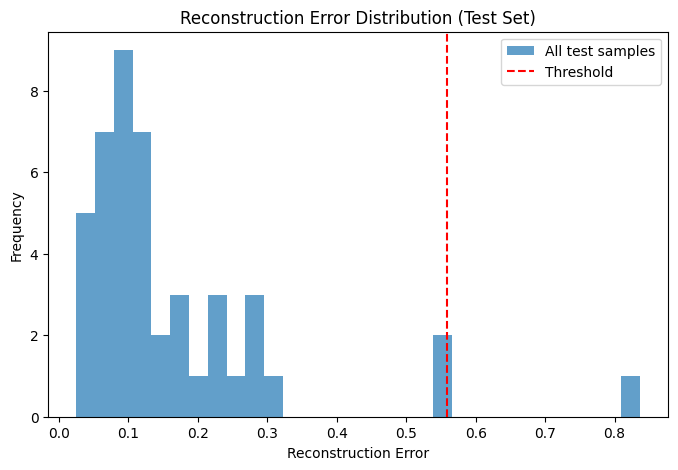

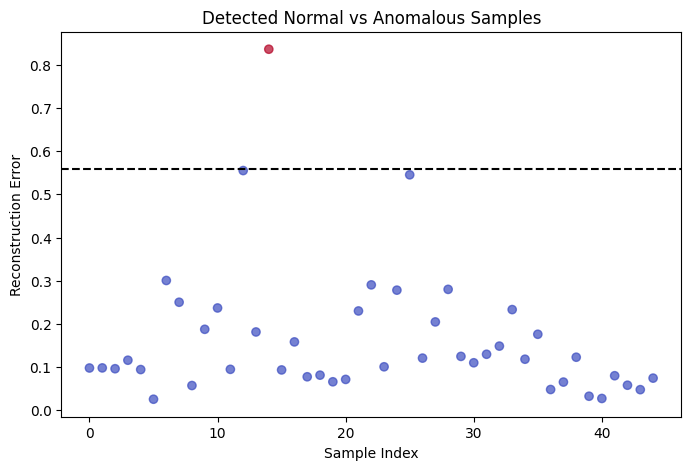

In [29]:
# ANALYSIS AND REPORTING OF DETECTED ANOMALIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Basic statistics

total_samples = len(test_recon_error)
num_anomalies = np.sum(y_test_pred)
num_normal = total_samples - num_anomalies
anomaly_percentage = (num_anomalies / total_samples) * 100

print("===== Anomaly Detection Summary =====")
print("Total test samples:", total_samples)
print("Detected normal samples:", num_normal)
print("Detected anomalies:", num_anomalies)
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")

# 2. Reconstruction error statistics

print("\n===== Reconstruction Error Statistics =====")
print("Min error:", np.min(test_recon_error))
print("Mean error:", np.mean(test_recon_error))
print("Max error:", np.max(test_recon_error))
print("Threshold used:", threshold)

# 3. Extract anomalous samples

anomaly_indices = np.where(y_test_pred == 1)[0]

anomaly_df = pd.DataFrame(X_test_scaled[anomaly_indices])
anomaly_df["reconstruction_error"] = test_recon_error[anomaly_indices]

print("\nDetected anomaly samples:")
display(anomaly_df.head())

# 4. Visualization: Reconstruction error distribution

plt.figure(figsize=(8, 5))
plt.hist(test_recon_error, bins=30, alpha=0.7, label="All test samples")
plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution (Test Set)")
plt.legend()
plt.show()

# 5. Visualization: Normal vs Anomaly comparison

plt.figure(figsize=(8, 5))
plt.scatter(
    range(len(test_recon_error)),
    test_recon_error,
    c=y_test_pred,
    cmap="coolwarm",
    alpha=0.7
)
plt.axhline(threshold, color="black", linestyle="--")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error")
plt.title("Detected Normal vs Anomalous Samples")
plt.show()